In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard, make_moons, make_circles,make_swiss_roll,make_s_curve,make_blobs
import torch

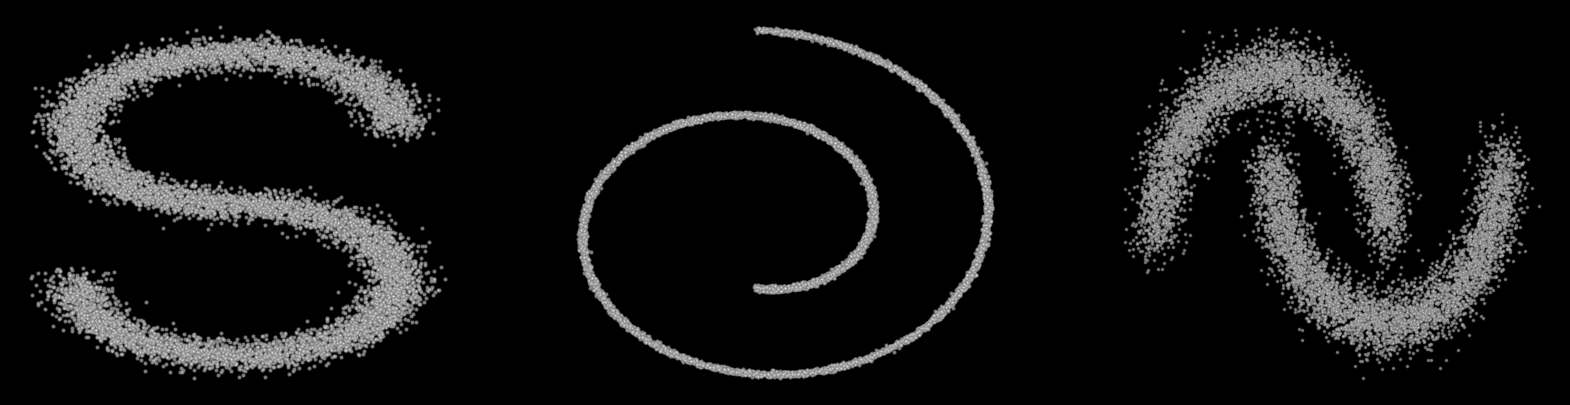

In [2]:
from helper_plot import hdr_plot_style
from utils import *
hdr_plot_style()
swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.0

s_curve, _= make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

moons, _ = make_moons(10**4, noise=0.1)

data = s_curve.T
#dataset = torch.Tensor(data.T).float()

fig,axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[0].axis('off')

data = swiss_roll.T
axes[1].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=5);
axes[1].axis('off')
#dataset = torch.Tensor(data.T).float()

data = moons.T
axes[2].scatter(*data, alpha=0.5, color='white', edgecolor='gray', s=3);
axes[2].axis('off')
dataset = torch.Tensor(data.T).float()

In [3]:
num_steps = 100
betas = make_beta_schedule('sigmoid',num_steps,1e-5,0.5e-2)

alphas = 1 - betas
alphas_prod = np.cumprod(alphas)
alphas_prod_p = torch.cat([torch.tensor([1.0]),torch.tensor(alphas_prod[:-1])])
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1.0 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1.0 - alphas_prod)

/tmp/ipykernel_3084676/154010046.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alphas_prod_p = torch.cat([torch.tensor([1.0]),torch.tensor(alphas_prod[:-1])])


In [4]:
def q_x(x_0,t,noise = None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt,t,x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt,t,x_0)
    return alphas_t*x_0 + alphas_1_m_t*noise

findfont: Generic family 'sans-serif' not found because none of the following families were found: Courier New
findfont: Generic family 'sans-serif' not found because none of the following families were found: Courier New
findfont: Generic family 'sans-serif' not found because none of the following families were found: Courier New
findfont: Generic family 'sans-serif' not found because none of the following families were found: Courier New
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Courier New
findfont: Generic family 'sans-serif' not found because none of the following families were found: Courier New
findfont: Generic family 'sans-serif' not found because none of the following families were found: Courier New
findfont: Generic family 'sans-serif' not found because none of the following families were found: Courier New
findfont: Generic family 'sans-seri

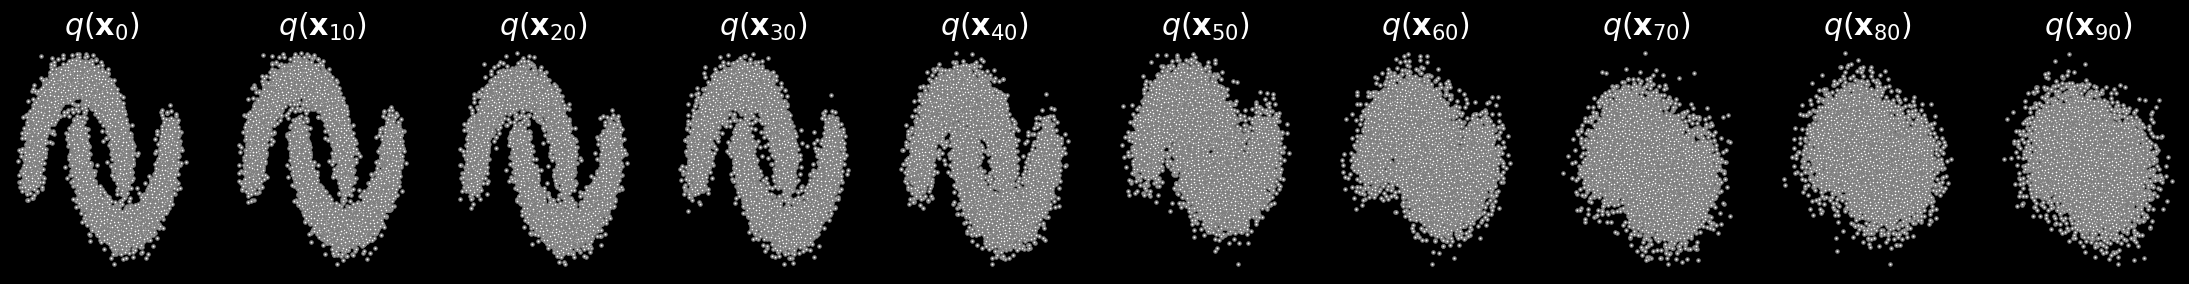

In [5]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='gray', s=5);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

In [6]:
#p(x_t-1|xt,x0)
#betas = 1-alphas
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

## training

In [7]:
from model import ConditionalModel
from ema import EMA
import torch.optim as optim

model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
            axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

tensor(1.1815, grad_fn=<MeanBackward0>)
tensor(0.6961, grad_fn=<MeanBackward0>)
tensor(0.4843, grad_fn=<MeanBackward0>)
tensor(0.6593, grad_fn=<MeanBackward0>)
tensor(0.5680, grad_fn=<MeanBackward0>)
